In [1]:
import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt

from diffrax import Tsit5, Kvaerno5

from models import NeuralODE, MLPVectorField, GFINN, NMS, BasicParam, FEMS
from system import SystemTrajectoryGenerator
from train import Trainer

print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default backend: cpu


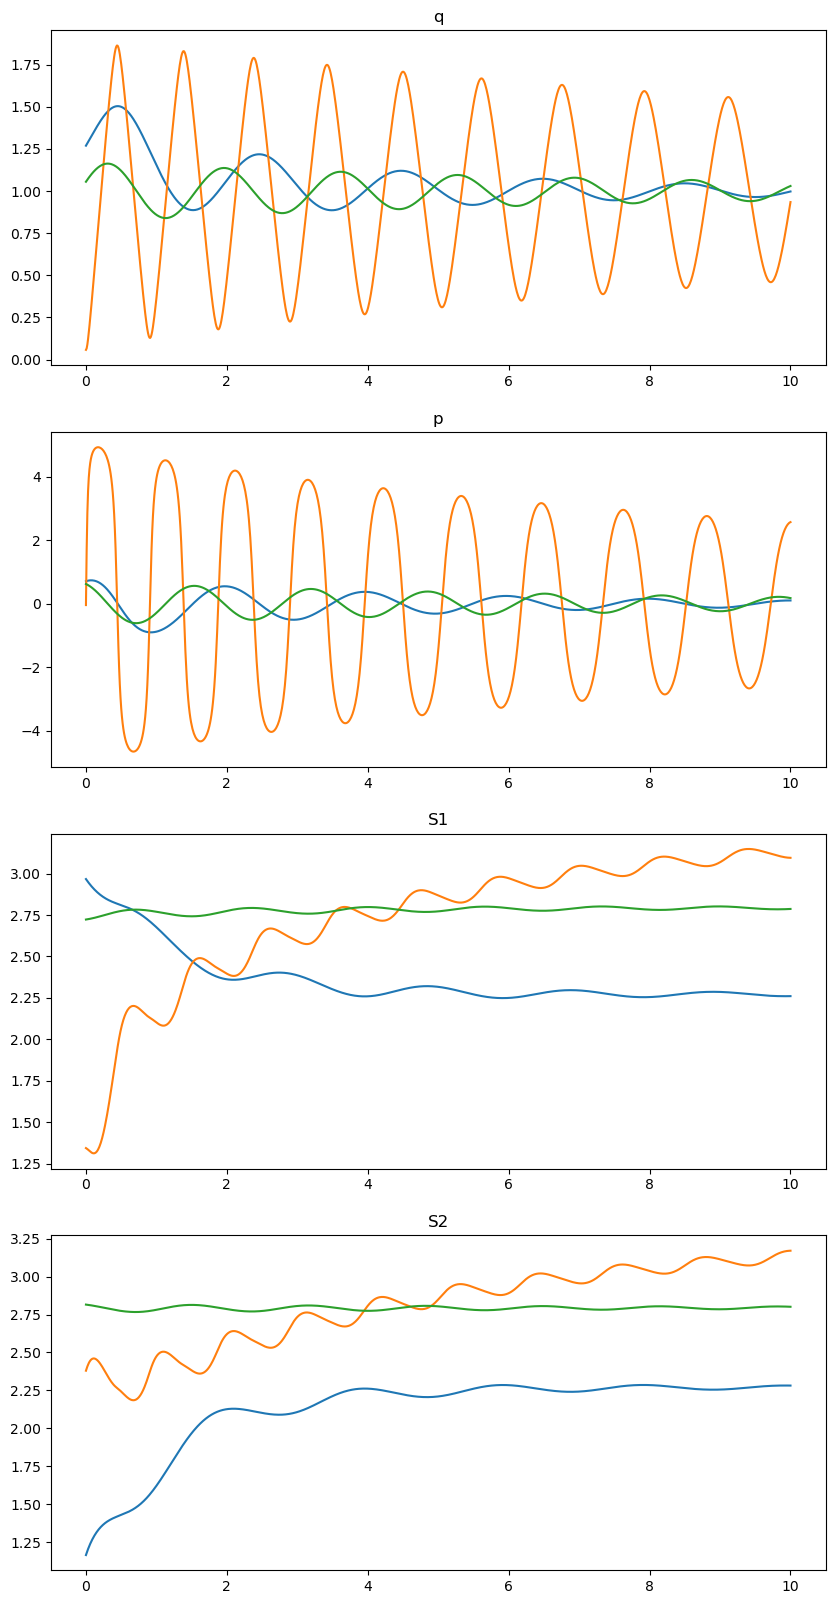

In [2]:
def SackurTetrode(S,Nkb,c_hat,V):
        return jnp.power(jnp.exp(S/Nkb)/(c_hat*V),2.0/3.0)

def M_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L, c_hat, A_char = args
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L - q)
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    factor = 9.0 * (Nkb**2) * alpha / 4.0
    
    M = jnp.zeros((4, 4), dtype=x.dtype)
    M = M.at[2, 2].set(factor / (E1**2))
    M = M.at[2, 3].set(-factor / (E1 * E2))
    M = M.at[3, 2].set(-factor / (E1 * E2))
    M = M.at[3, 3].set(factor / (E2**2))
    
    return M

def E_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L_, c_hat, A_char = args
    
    E_kin = p**2 / (2 * m)
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L_ - q)
    
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    return E_kin + E1 + E2

def S_gas(x, args):
    q, p, S1, S2 = x
    return S1 + S2

def L_gas(x, args):
    return jnp.array([
        [0.,  1., 0., 0.],
        [-1., 0., 0., 0.],
        [0.,  0., 0., 0.],
        [0.,  0., 0., 0.],
    ], dtype=x.dtype)

def gradE_gas(x, args):
    return jax.grad(lambda x_: E_gas(x_, args))(x)

def gradS_gas(x, args):
    return jax.grad(lambda x_: S_gas(x_, args))(x)

def two_gas_container(t, y, args):
    L = L_gas(y, args)
    M = M_gas(y, args)
    grad_E = gradE_gas(y, args)
    grad_S = gradS_gas(y, args)
    return L@grad_E + M@grad_S

Nkb = 1 # Number of particles and Boltzmann constant (characteristic unit of entropy)
m = 1 # Mass of wall
alpha = 8 # Gruber sets it at 1
length = 1 # Distance from origin to the middle of the container (equilibrium wall position)
c_hat = 1 # Energy normalization, Gruber sets it at exp(102.2476703501216)
A_char = 1 # Average cross-sectional area
args = (Nkb, m, alpha, length, c_hat, A_char)

dim = 4
system = SystemTrajectoryGenerator(two_gas_container, dim, Tsit5(), ["q", "p", "S1", "S2"], args=args)

key = jax.random.PRNGKey(42)
n_traj = 3
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([1.75, 2, 2.0, 2.0]) + jnp.array([0.0, -1.0, 1.0, 1.0])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

In [ ]:
key = jax.random.PRNGKey(42)
model = NeuralODE(MLPVectorField, system.dim, 64, 2, 0.01, key=key)
trainer = Trainer(system, model=model, lr=1e-3, save_dir="node_tgc/")
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=100, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[0.25,-2,1,1], 
                                                  maxs=[1.75,2,3,3], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 10],
                                                  nrand=[100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

--------------------

Training until time 1.000100010001, with 100 samples.

--------------------
Epoch: 0
Train loss: 0.5789252277951051, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.05033817390449141, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.09891018441025329, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.09840137061451125, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.29971212807317754, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.061023185662053545, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.0338061169547686, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.04199275275578139, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.01525832369556728, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.015581253471858446, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.10127848088650147, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11
Train loss: 0.04340

In [3]:
key = jax.random.PRNGKey(0)
model = NeuralODE(GFINN, system.dim, 8, 4, 0.01, K=4, key=key)
trainer = Trainer(system, model=model, lr=1e-3, save_dir="gfinn_tgc/")
model, train_losses, valid_losses = trainer.train(N=256, 
                                                  N_valid=4,
                                                  n_epochs=2048, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[0.99,0.99,1.99,1.99], 
                                                  maxs=[1.01,1.01,2.01,2.01],
                                                  ts_train=jnp.linspace(0, 8, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 8],
                                                  nrand=[100, 1000],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

/Users/aballester3/Projects/NODE/synaptic/models.py:170: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.LgradS = GFINNComponent(dim, width, depth, K, "L", key=key1)
/Users/aballester3/Projects/NODE/synaptic/models.py:171: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.MgradE = GFINNComponent(dim, width, depth, K, "M", key=key2)


--------------------

Training until time 1.0001000100010002 (1250 total samples), with 100 samples.

--------------------
Epoch: 0
Train loss: 0.010481226477038402, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.158699720645956, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.2034608726800502, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.004660186201101941, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.014293285250549301, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.004262808890488774, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.10859147223772735, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.007791747134262363, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.00852649209816976, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.022431461100721636, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.09914084083526573, Valid loss: 0
Saving model at epoch 10
--------------------
E

In [3]:
key = jax.random.PRNGKey(0)
model = NeuralODE(FEMS, system.dim, 8, 4, 0.01, key=key)
trainer = Trainer(system, model=model, lr=1e-3, save_dir="fems_tgc_multi/")
model, train_losses, valid_losses = trainer.train(N=256, 
                                                  N_valid=4,
                                                  n_epochs=2048, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[0.2,-1.8,1.2,1.2], 
                                                  maxs=[1.8,1.8,2.8,2.8],
                                                  ts_train=jnp.linspace(0, 8, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 8],
                                                  nrand=[100, 1000],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True,
                                                  diagnostics=True)

--------------------

Training until time 1.0001000100010002 (1250 total samples), with 100 samples.

--------------------
Epoch: 0
Train loss: 0.25539130667795673, Valid loss: 0
--------------------
Epoch: 1
Train loss: 1.0852073156473327, Valid loss: 0
--------------------
Epoch: 2
Train loss: 1.0293499267745896, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.36882364496561193, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.31306450273875147, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.35173325831754065, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.767905912552351, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.31617831052183326, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.3385401565339322, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.40152248521966444, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.9758438808857737, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11


In [3]:
key = jax.random.PRNGKey(0)
model = NeuralODE(NMS, system.dim, 64, 2, 0.01, 
                  lE=2,
                  lS=2,
                  lA=2,
                  lB=2, 
                  lD=2, 
                  nE=32, 
                  nS=32, 
                  nA=32, 
                  nB=32, 
                  nD=32, 
                  D=3, 
                  C2=3, 
                  key=key)


trainer = Trainer(system, model=model, lr=1e-3, save_dir="nms_tgc_no_entropy/")
model, train_losses, valid_losses = trainer.train(N=256, 
                                                  N_valid=4,
                                                  n_epochs=3750, 
                                                  bs=32, 
                                                  bs_valid=2,
                                                  mins=[0.99,0.99,1.99,1.99], 
                                                  maxs=[1.01,1.01,2.01,2.01],
                                                  ts_train=jnp.linspace(0, 8, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 8],
                                                  nrand=[100, 1000],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True,
                                                  diagnostics=True,
                                                  nobs=slice(0,2))

DataLoader: Ignoring 2 entropy dimensions.
DataLoader: Added 2 virtual entropy dimensions.
DataLoader: Ignoring 2 entropy dimensions.
DataLoader: Added 2 virtual entropy dimensions.
--------------------

Training until time 1.0001000100010002 (1250 total samples), with 100 samples.

--------------------
Epoch: 0
Train loss: 0.01557120843065064, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.34058818616970854, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.39600865628143067, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.009243793603486124, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.01877052367429495, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.009750999906389632, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.2471795385681691, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.016779055669625384, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.014497730166585855, Valid loss: 0
--------------------

Shape of generated trajectories: (2, 10000, 4)
Shape of trajectories with virtual entropy: (2, 10000, 4)
MSE over last 10 seconds:  0.001956383118993537


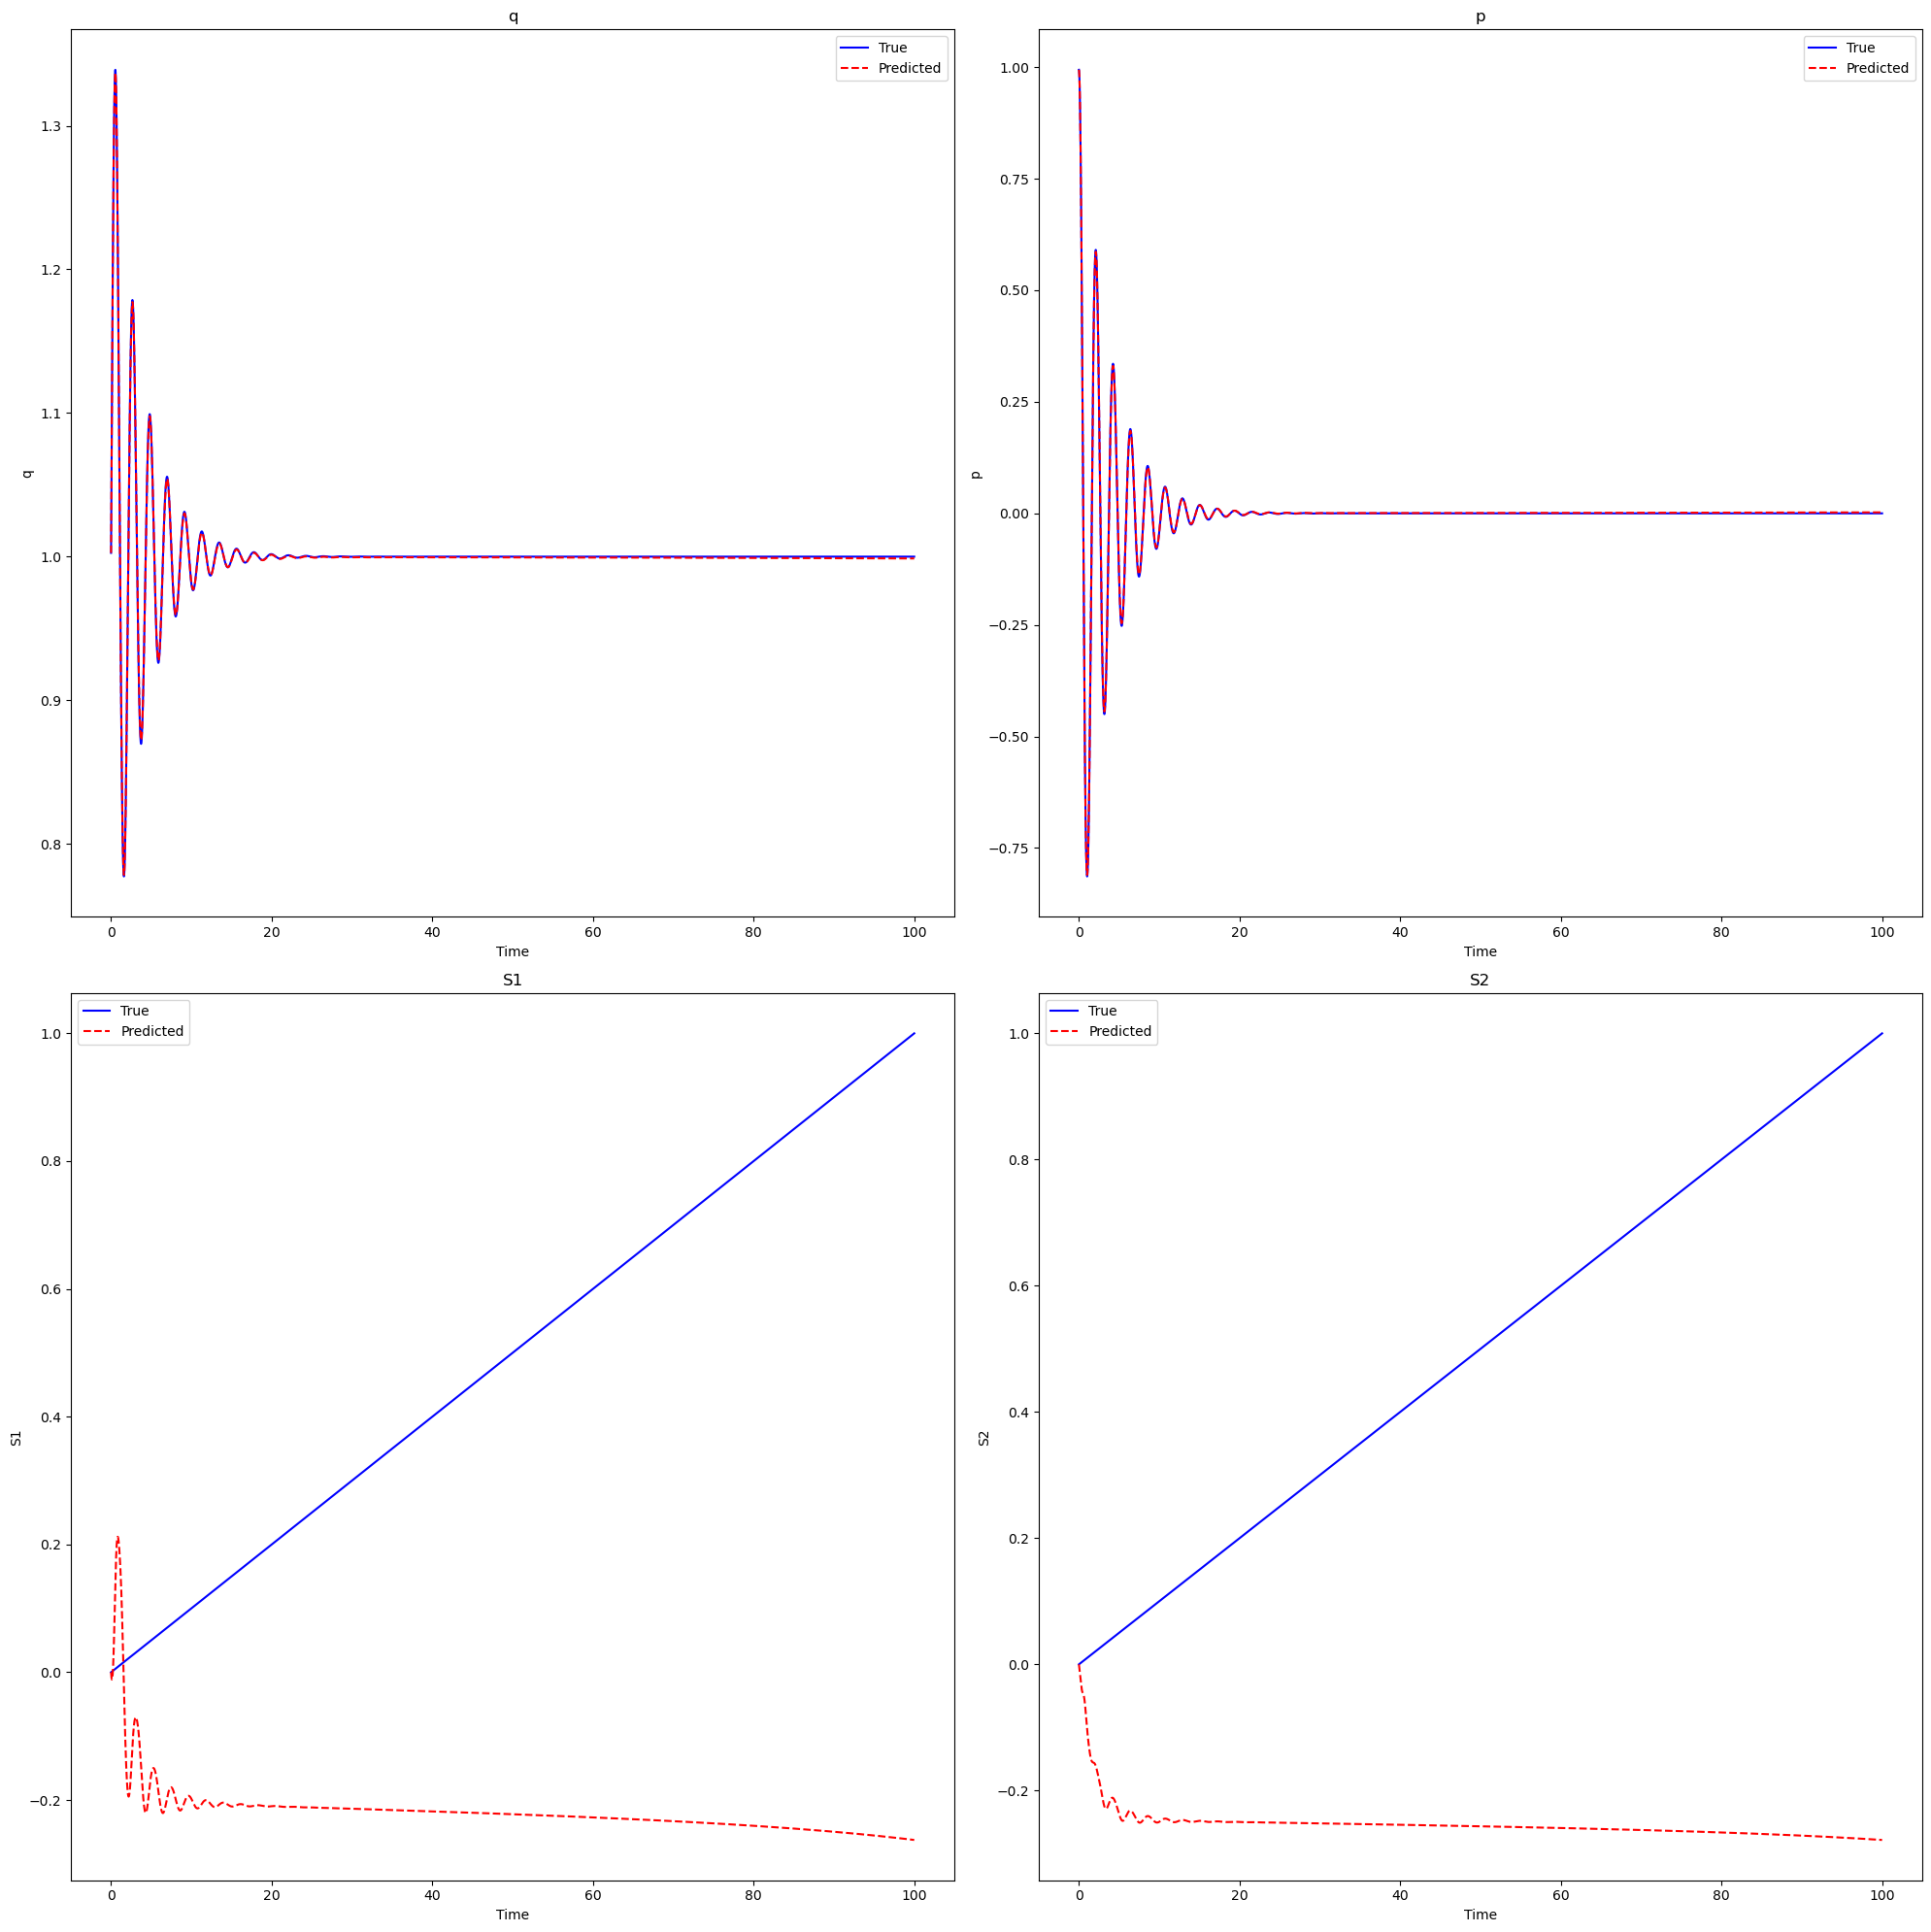

In [9]:
# load model
model = NeuralODE.load_model("nms_tgc_no_entropy/model_checkpoint_final")
# Create new dataset to evaluate the model in a different time window
low = jnp.array([0.99,0.99,1.99,1.99])
high = jnp.array([1.01,1.01,2.01,2.01])
n_traj = 2
y0s = jax.random.uniform(key, (n_traj, 4)) * (high - low) + low
n_times = 10000
ts = jnp.linspace(0, 100, n_times)
ts, y = system.trajectories_from_random_ics(n_traj, low, high, ts, ts[1]-ts[0]) # (100, 4000, 10)
print("Shape of generated trajectories:", y.shape)
nentropy = 2
y = y[:,:,:-nentropy]
virtual_entropy = jnp.linspace(0, 1, n_times)
virtual_entropy = jnp.broadcast_to(virtual_entropy[None, :, None], (n_traj, n_times, nentropy))
y = jnp.concatenate([y, virtual_entropy], axis=-1)
print("Shape of trajectories with virtual entropy:", y.shape)
y_pred = jax.vmap(model, in_axes=(None, 0))(ts, y[:,0,:])
y_pred = y_pred[:,:,:]
y_test = y[:, :, :]
mse = jnp.mean(jnp.mean(jnp.linalg.norm(y_pred[:,:,:-2] - y_test[:,:,:-2], axis=-1),axis=0),axis=0)
#mse = ((y_test[:,:,:] - y_pred[:,:,:]) ** 2).mean(axis=(1,2)).mean()
print("MSE over last 10 seconds: ", mse)

# plot predictions against true trajectories
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
labels = ["q", "p", "S1", "S2"]
index = 1
for i in range(4):
    ax = axs[i//2, i%2]
    ax.plot(ts[:], y_test[index,:,i], label="True", color="blue")
    ax.plot(ts[:], y_pred[index,:,i], label="Predicted", color="red", linestyle="dashed")
    ax.set_title(labels[i])
    ax.set_xlabel("Time")
    ax.set_ylabel(labels[i])
    ax.legend()
plt.tight_layout()
plt.show()

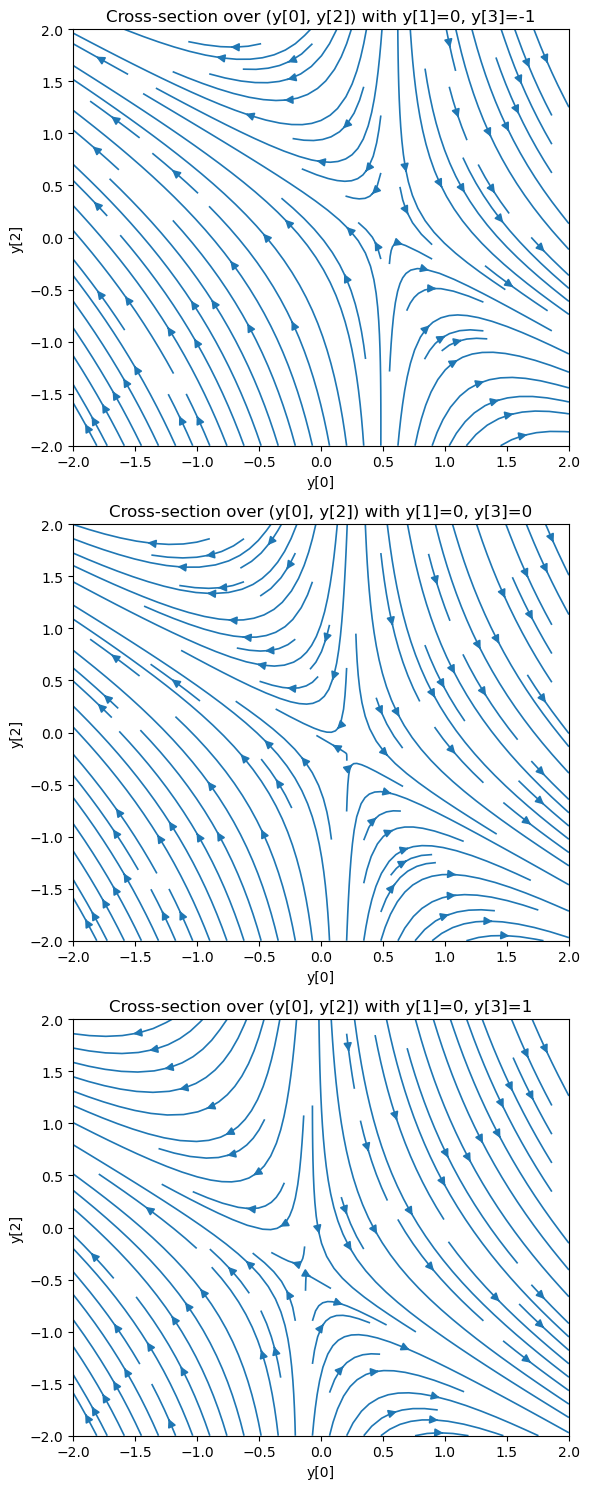

In [4]:
# Multiple cross-sections (creates one subplot per dict)
model.vector_field.plot(((-2, 2), (-2, 2)),
                        vary=(0, 2),
                        fixed=[{1: 0.0, 3: -1.0}, {1: 0.0, 3: 0.0}, {1: 0.0, 3: 1.0}],
                        t=0.0, kind="stream", stream_density=1.0)